<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

### Import Liberies

In [164]:
import pandas as pd
import numpy as np

# Feature Selection- Filter Methods
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from itertools import combinations

# For plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Lasso   # To go to inital cells if approved

### Load Data

In [165]:
# Load the processed datasets (train, validation, test)
X_train = pd.read_parquet("./project_data/X_train_final.parquet", engine="pyarrow")
X_val   = pd.read_parquet("./project_data/X_val_final.parquet",   engine="pyarrow")
X_test  = pd.read_parquet("./project_data/X_test_final.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")


# Check the shape of the training, validation and test data
print(X_train.shape, X_val.shape, X_test.shape)
print('\n',y_train.shape, y_val.shape)

(60764, 154) (15191, 154) (32567, 154)

 (60764,) (15191,)


### Config

In [166]:
DATASETS = [X_train, X_val , X_test]

<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

In this class, we will focus on a very important subset of pre-processing techniques, which is **Feature Selection**. When we have a dataset large numbers of features, it is very likely that some of them are **irrelevant**, **redundant** or **noisy**. These features can negatively impact the performance of our machine learning models:<br>
1. An additional feature is an additional dimension. This leads to a well-known problem called **curse of dimensionality**. As the number of dimensions increases, the volume of the space increases exponentially, making the available data sparse (essencially, we need more observations to fill the space) and, ultimately leading to overfitting.
2. Machine Learning Models are trained from the available data that is provided. In essence, given data, the algorithm will look (AND FIND) relationships between features and the target. If a feature is **irrelevant** or **noisy**, the models will learn from these features and find relationships that do not exist in the real world - often leading to overfitting.
3. Computationally speaking, redundant features provide no additional information, but they do increase the computational cost of training and using the model. Moreover, their presence makes a model more complex, harder to interpret, and worst case scenario, actually worse at generalizing.
</div>


<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods</b></span>
    </h1>
</div>


**Filter Methods** are techniques that rely on the **statistical properties** of the data rather than a specific machine learning model.  
They are **computationally efficient**, making them suitable for an **initial screening** of high-dimensional datasets.  
However, due to their simplicity, they are often considered **less effective** than *wrapper* or *embedded* methods, which depend on an underlying model.

In class, we explored **three main approaches**:

1. **Variance Threshold** – removes features with very low variance (constant or quasi-constant).  
2. **Correlation Indices** – identifies **redundant** features and, in some cases, measures the relationship with the target.  
3. **Statistical Hypothesis Testing** – evaluates statistically significant relationships between features and the target, helping to identify **relevant** variables.

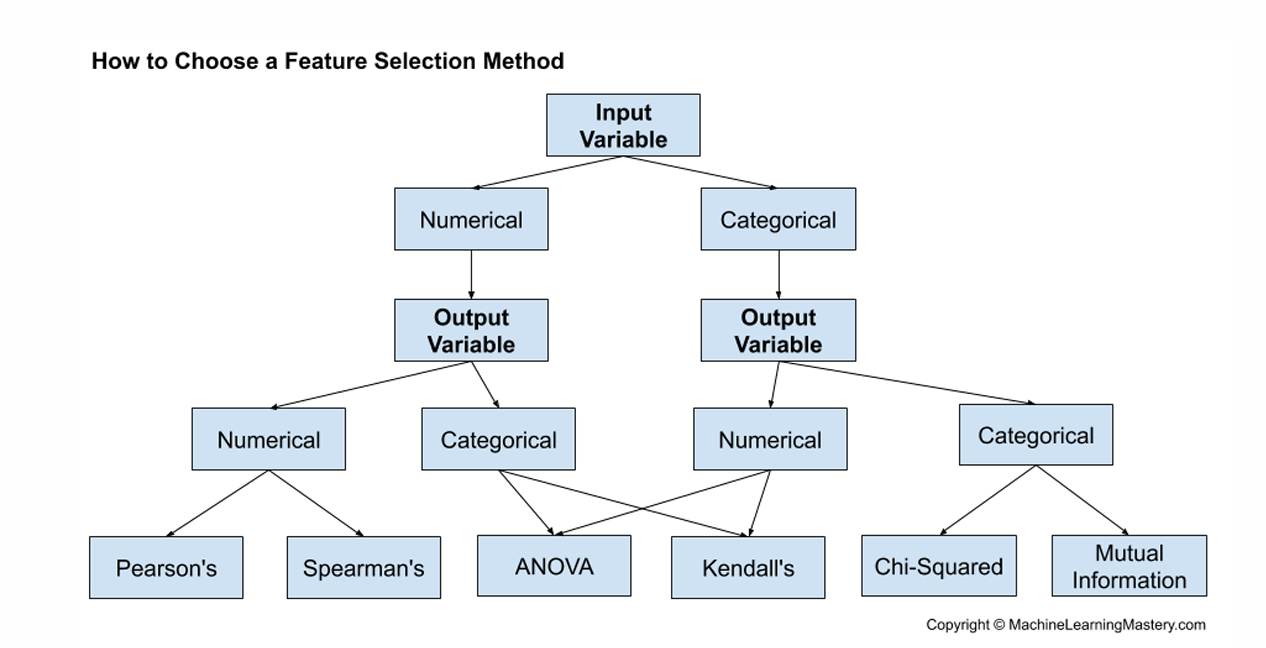

##### **Variance Threshold**

In [167]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)
#fit
X_train_sel = vart.fit(X_train)
# Get low variance columns and print them
low_variance = X_train.columns[vart.variances_ <= 0.01]
print(len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train.columns.get_loc(col)]:.4f}")

101
Features with variance closer to zero:
hasDamage: 0.0000
Brand_None: 0.0006
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022
brand_model_Audi_A5: 0.0079
brand_model_Audi_A6: 0.0061
brand_model_Audi_A7: 0.0011
brand_model_Audi_A8: 0.0011
brand_model_Audi_None: 0.0039
brand_model_Audi_Q2: 0.0069
brand_model_Audi_Q5: 0.0076
brand_model_Audi_Q7: 0.0035
brand_model_Audi_TT: 0.0029
brand_model_Audi_other: 0.0028
brand_model_BMW_4 Series: 0.0084
brand_model_BMW_5 Series: 0.0096
brand_model_BMW_M4: 0.0011
brand_model_BMW_None: 0.0024
brand_model_BMW_X1: 0.0074
brand_model_BMW_X2: 0.0024
brand_model_BMW_X3: 0.0048
brand_model_BMW_X4: 0.0014
brand_model_BMW_X5: 0.0041
brand_model_BMW_Z4: 0.0010
brand_model_BMW_other: 0.0050
brand_model_Ford_B-MAX: 0.0032
brand_model_Ford_C-MAX: 0.0050
brand_model_Ford_Ka: 0.0001
brand_model_Ford_Ka+: 0.0065
brand_model_Ford_Mondeo: 0.0047
brand_model_Ford_None: 0.0041
brand_model_Ford_S-MAX: 0.0027
brand_model_Ford_other: 0.0088
br

<div style="background-color:#f9f9f9; border:1.5px solid #ccc; border-radius:8px; padding: 10px; width:1130px; text-align: justify;">
DESDE MUITO CEDO SABÍAMOS QUE HASDAMAGE NÃO TINHA MUITA RELEVÂNCIA E QUANDO FIZEMOS INPUTATION SÓ TINHAMOS VALORES COM 0 ENTÃO FICOU TUDO A ZERO O QUE IMPLICA QUE ESTA VARIÁVEL É COMPLETAMENTE IRRELEVANTE PARA O NOSSO MODELO PELO QUE PODEMOS DESCARTÁ-LA

In [168]:
DATASETS = [X_train, X_val , X_test]
# Drop column 'hasDamage' from X_train, X_val, X_test
for d in DATASETS:
    d = d.drop(columns=low_variance, errors='ignore', inplace=True)

##### **Correlation Indices**

<div style="background-color:#f9f9f9; border:1.5px solid #ccc; border-radius:8px; padding: 10px; width:1130px; text-align: justify;">
EXPLICAR A RAZÃO DE USAR SPEARMAN VS PEARSON E PARA QUE VARIÁVEIS <br>
</div>

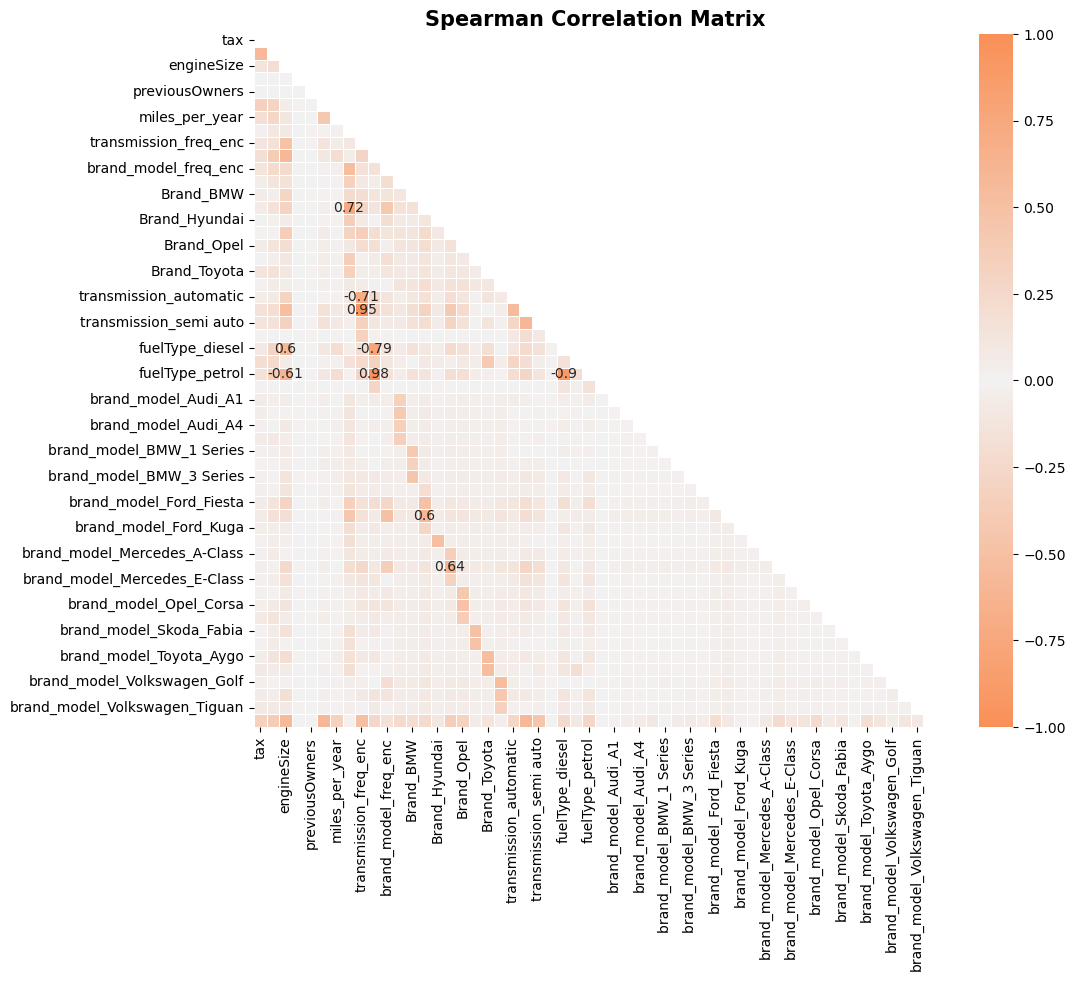

In [169]:
##### Spearman Correlation #### 
cor = pd.concat([X_train, y_train], axis=1).corr(method='spearman').round(2)                       

# Create a custom diverging colormap based on orange tones
cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# Create a Mask to hide the upper triangle (to avoid redundancy)
mask = np.zeros_like(cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Only show values where absolute correlation is >= 0.4
mask_annot = np.absolute(cor.values) >= 0.6
annot = np.where(mask_annot, cor.values, np.full(cor.shape, ""))


# Plotting
plt.figure(figsize=(11, 9))
sns.heatmap(
    data=cor,
    mask=mask,              # Hide the upper triangle
    cmap=cmap,              # Custom divergent color map
    annot=annot,            # Show annotations only if |value| >= 0.4
    fmt='s',                # Format annotations as strings
    vmin=-1, vmax=1, center=0, # Ensure the scale is from -1 to 1, centered at 0
    linewidths=0.5, 
)

plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
plt.show()

In [170]:
# Matriz de correlação sem o target
cor_no_target = cor.drop(index="price", columns="price", errors="ignore")

# Define threshold para considerar “alta correlação”
threshold = 0.9

# Pega pares de variáveis fortemente correlacionadas
high_corr_pairs = (
    cor_no_target
    .where(np.triu(np.ones(cor_no_target.shape), k=1).astype(bool))  # upper triangle only
    .stack()
    .reset_index()
    .rename(columns={"level_0": "var1", "level_1": "var2", 0: "corr"})
)

# Filtra pelos pares com |corr| acima do threshold
high_corr_pairs = high_corr_pairs[high_corr_pairs["corr"].abs() > threshold]

if not high_corr_pairs.empty:
    print(f"Variables highly correlated (|Spearman| > {threshold}):")
    display(high_corr_pairs.sort_values("corr", key=np.abs, ascending=False))
else:
    print(f"No variable pairs found with |Spearman| > {threshold}.")


Variables highly correlated (|Spearman| > 0.9):


,var1,var2,corr
448,fuelType_freq_enc,fuelType_petrol,0.98
400,transmission_freq_enc,transmission_manual,0.95


In [171]:
# Drop column 
high_corr = ['Brand_None','brand_model_None_None', 'fuelType_freq_enc','transmission_freq_enc'], 
for d in DATASETS:
    d = d.drop(columns=low_variance, errors='ignore', inplace=True)

In [172]:
X_train.shape

(60764, 53)

In [173]:
cor_target = cor['price']
# Define a threshold for correlation with target variable to identify irrelevant variables
threshold = 0.01

# Identify features with low correlation to the target variable
low_corr_features = cor_target[abs(cor_target) < threshold].drop('price', errors='ignore') #drop 'price' because the correlation of target with itself is always 1

# Print the results
if not low_corr_features.empty:
    print(f"The variables with absolute Spearman correlation below {threshold}:")
    print(low_corr_features)
else:
    print(f"No variables found with absolute correlation below {threshold}.")

The variables with absolute Spearman correlation below 0.01:
paintQuality%               0.0
previousOwners             -0.0
transmission_unknown        0.0
fuelType_unknown            0.0
brand_model_BMW_1 Series    0.0
Name: price, dtype: float64


In [174]:
low_corr_features = cor_target[cor_target.abs() < threshold].index.tolist()
for d in DATASETS:
    d = d.drop(columns=low_corr_features, errors='ignore', inplace=True)

In [175]:
X_train.shape

(60764, 48)

We decided to remove the three variables with the lowest absolute correlation with the target variable — `paintQuality%`, `previousOwners`, and `Brand_freq_enc` — since their correlation values were close to zero. The fourth variable, `brand_model_freq_enc`, was kept for now, as despite its low correlation, it might still hold some useful information for the model.

In [176]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# 1. INFORMAÇÃO MÚTUA (MUTUAL INFORMATION)
# ============================================================================

def mutual_information_selection(X, y, k=10):
    # Calcular scores de informação mútua
    mi_scores = mutual_info_regression(X, y, random_state=42)
    
    # Criar DataFrame com scores
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    scores_df = pd.DataFrame({
        'feature': feature_names,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    # Selecionar top k features
    selected_features = scores_df.head(k)['feature'].tolist()
    
    print(f"=== MUTUAL INFORMATION ===")
    print(f"\nTop {k} features selecionadas:")
    print(scores_df.head(k))
    
    # Plotar scores
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(scores_df)), scores_df['mi_score'])
    plt.yticks(range(len(scores_df)), scores_df['feature'])
    plt.xlabel('Mutual Information Score')
    plt.title('Feature Importance - Mutual Information')
    plt.tight_layout()
    plt.show()
    
    return selected_features, scores_df

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.2 |  Wrapper Methods</b></span>
    </h1>
</div>

In [177]:
# ============================================================================
# 2. RECURSIVE FEATURE ELIMINATION (RFE)
# ============================================================================

def rfe_selection(X, y, n_features=10, estimator=None):
    if estimator is None:
        estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Aplicar RFE
    rfe = RFE(estimator=estimator, n_features_to_select=n_features)
    rfe.fit(X, y)
    
    # Obter nomes das features
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    # Criar DataFrame com ranking
    ranking_df = pd.DataFrame({
        'feature': feature_names,
        'selected': rfe.support_,
        'ranking': rfe.ranking_
    }).sort_values('ranking')
    
    selected_features = ranking_df[ranking_df['selected']]['feature'].tolist()
    
    print(f"\n=== RECURSIVE FEATURE ELIMINATION (RFE) ===")
    print(f"\nFeatures selecionadas (ranking = 1):")
    print(ranking_df[ranking_df['selected']])
    print(f"\nFeatures eliminadas:")
    print(ranking_df[~ranking_df['selected']])
    
    # Plotar ranking
    plt.figure(figsize=(10, 6))
    colors = ['green' if s else 'red' for s in ranking_df['selected']]
    plt.barh(range(len(ranking_df)), ranking_df['ranking'], color=colors)
    plt.yticks(range(len(ranking_df)), ranking_df['feature'])
    plt.xlabel('Ranking (1 = selecionada)')
    plt.title('Feature Ranking - RFE')
    plt.tight_layout()
    plt.show()
    
    return selected_features, ranking_df

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.3 |  Embedded Methods</b></span>
    </h1>
</div>

In [178]:

# ============================================================================
# 3. REGULARIZAÇÃO L1 (LASSO)
# ============================================================================

def lasso_selection(X, y, alpha=None, threshold=1e-5, pre_scaled=False):
    # Padronizar features apenas se ainda não estiverem escaladas
    if pre_scaled:
        X_scaled = X
        print("Usando dados já escalados (RobustScaler)")
    else:
        print("Aplicando StandardScaler...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    
    # Se alpha não fornecido, usar Cross-Validation
    if alpha is None:
        print("Usando LassoCV para encontrar melhor alpha...")
        lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
        lasso.fit(X_scaled, y)
        best_alpha = lasso.alpha_
        print(f"Melhor alpha encontrado: {best_alpha:.6f}")
    else:
        lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
        lasso.fit(X_scaled, y)
        best_alpha = alpha
    
    # Obter coeficientes
    coefs = lasso.coef_
    
    # Obter nomes das features
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    # Criar DataFrame com coeficientes
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coefficient': np.abs(coefs)
    }).sort_values('abs_coefficient', ascending=False)
    
    # Selecionar features com coeficiente != 0
    selected_features = coef_df[coef_df['abs_coefficient'] > threshold]['feature'].tolist()
    
    print(f"\n=== LASSO (L1 REGULARIZATION) ===")
    print(f"Alpha usado: {best_alpha:.6f}")
    print(f"\nFeatures selecionadas ({len(selected_features)}):")
    print(coef_df[coef_df['abs_coefficient'] > threshold])
    print(f"\nFeatures eliminadas ({len(coef_df) - len(selected_features)}):")
    print(coef_df[coef_df['abs_coefficient'] <= threshold])
    
    # Plotar coeficientes
    plt.figure(figsize=(10, 6))
    colors = ['green' if abs(c) > threshold else 'red' for c in coef_df['coefficient']]
    plt.barh(range(len(coef_df)), coef_df['coefficient'], color=colors)
    plt.yticks(range(len(coef_df)), coef_df['feature'])
    plt.xlabel('Coeficiente Lasso')
    plt.title(f'Feature Coefficients - Lasso (alpha={best_alpha:.6f})')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    return selected_features, coef_df, lasso


##  Decision Table

| Predictor | Spearman | RFE LR| RFE SVM | Lasso | What to do?  | 
| --- | --- | --- | --- |--- |---|
| VAR1 | Keep | Keep | Keep |Keep | Keep |
| VAR2 | Keep | Keep | Keep |Keep| Discard |
| VAR3 | Keep?| Discard | Discard |Keep ?| Discard |
| VAR4 | Keep | Keep | Keep | Keep | Keep |
| VAR5 | Keep? | Discard | Keep | Keep | Keep |

EXEMPLO COM SEUS DADOS - X_train e y_train

# PASSO 1: Criar tabela de decisão
decision_table = create_feature_decision_table(
    X_train,
    y_train,
    n_features=10,
    corr_threshold_high=0.95,
    corr_threshold_low=0.1,
    variance_threshold=0.01
)

# PASSO 2: Ver a tabela
print(decision_table)

# PASSO 3: Pegar features recomendadas
features_keep = decision_table[decision_table['What_to_do?'] == 'Keep']['Predictor'].tolist()

# PASSO 4: Aplicar no treino e teste
X_train_selected = X_train[features_keep]
X_test_selected = X_test[features_keep]

# PASSO 5: Ver gráficos
plot_decision_summary(decision_table)


EXECUTANDO EXEMPLO COM DADOS FICTÍCIOS

Calculando métricas de feature selection...

1. Calculando correlação com target...
2. Calculando variância...
3. Verificando correlações altas entre features...
4. Calculando Mutual Information...
5. Aplicando RFE com Linear Regression...
6. Aplicando RFE com SVM...


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


7. Aplicando Lasso...
8. Calculando correlação Spearman...

9. Criando tabela de decisão...


TABELA DE DECISÃO - FEATURE SELECTION
Predictor Spearman  RFE_LR RFE_SVM   Lasso What_to_do?
     VAR1     Keep    Keep    Keep    Keep        Keep
     VAR3     Keep    Keep    Keep    Keep        Keep
     VAR6     Keep    Keep    Keep    Keep        Keep
     VAR5     Keep    Keep    Keep Discard        Keep
    VAR13     Keep    Keep    Keep Discard        Keep
     VAR7     Keep    Keep    Keep Discard     Discard
     VAR2  Discard    Keep Discard    Keep     Discard
    VAR14  Discard    Keep    Keep Discard     Discard
     VAR9     Keep Discard    Keep Discard     Discard
     VAR4  Discard    Keep    Keep Discard     Discard
     VAR8  Discard    Keep    Keep Discard     Discard
    VAR10  Discard Discard Discard Discard     Discard
    VAR11  Discard Discard Discard Discard     Discard
    VAR12  Discard Discard Discard Discard     Discard
    VAR15  Discard Discard Discard Discard 

c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


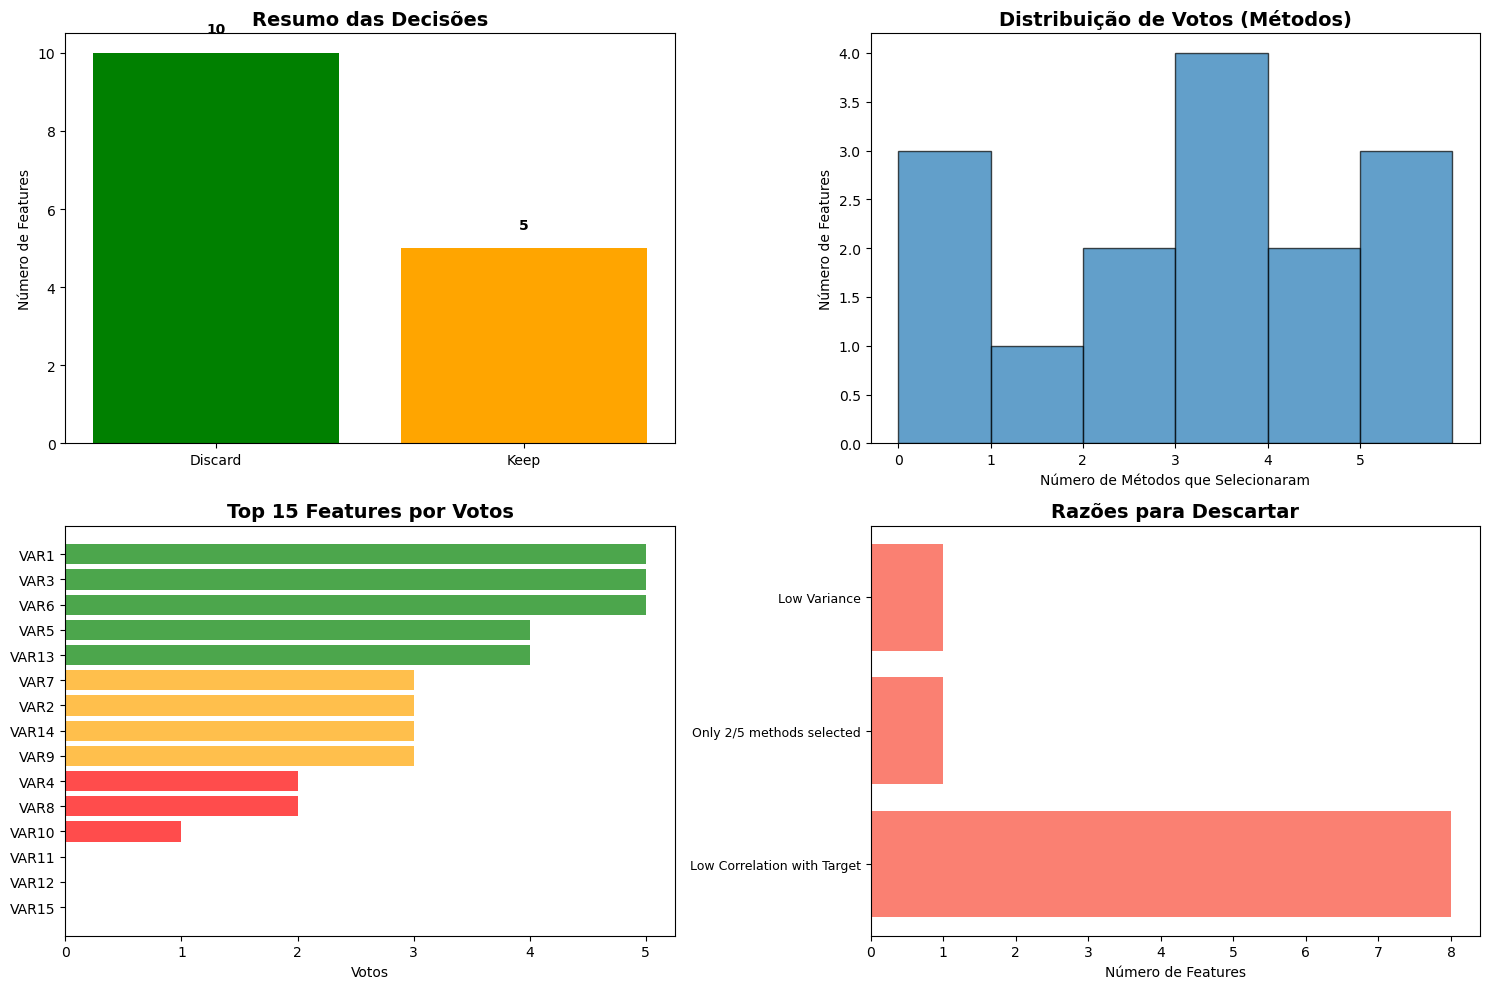

In [179]:

# ============================================================================
# 4. TABELA DE DECISÃO COMPLETA
# ============================================================================

def create_feature_decision_table(X_train, y_train, n_features=10, 
                                   corr_threshold_high=0.95, 
                                   corr_threshold_low=0.1,
                                   variance_threshold=0.01):
    
    feature_names = X_train.columns.tolist()
    results = []
    
    print("Calculando métricas de feature selection...\n")
    
    # ========================================================================
    # 1. CORRELAÇÃO COM TARGET
    # ========================================================================
    print("1. Calculando correlação com target...")
    corr_with_target = X_train.corrwith(pd.Series(y_train, index=X_train.index)).abs()
    
    # ========================================================================
    # 2. VARIÂNCIA
    # ========================================================================
    print("2. Calculando variância...")
    variances = X_train.var()
    
    # ========================================================================
    # 3. CORRELAÇÃO ALTA ENTRE FEATURES (redundância)
    # ========================================================================
    print("3. Verificando correlações altas entre features...")
    corr_matrix = X_train.corr().abs()
    
    # Para cada feature, verificar se tem correlação alta com outra
    high_corr_pairs = {}
    for feature in feature_names:
        # Encontrar features com correlação alta (excluindo consigo mesma)
        high_corr = corr_matrix[feature][corr_matrix[feature] > corr_threshold_high]
        high_corr = high_corr[high_corr.index != feature]
        if len(high_corr) > 0:
            high_corr_pairs[feature] = high_corr.index.tolist()
    
    # ========================================================================
    # 4. MUTUAL INFORMATION
    # ========================================================================
    print("4. Calculando Mutual Information...")
    mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
    mi_ranking = pd.Series(mi_scores, index=feature_names).rank(ascending=False)
    
    # ========================================================================
    # 5. RFE com Linear Regression
    # ========================================================================
    print("5. Aplicando RFE com Linear Regression...")
    rfe_lr = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
    rfe_lr.fit(X_train, y_train)
    rfe_lr_selected = rfe_lr.support_
    
    # ========================================================================
    # 6. RFE com SVM
    # ========================================================================
    print("6. Aplicando RFE com SVM...")
    rfe_svm = RFE(estimator=SVR(kernel='linear'), n_features_to_select=n_features)
    rfe_svm.fit(X_train, y_train)
    rfe_svm_selected = rfe_svm.support_
    
    # ========================================================================
    # 7. LASSO
    # ========================================================================
    print("7. Aplicando Lasso...")
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_coefs = np.abs(lasso.coef_)
    lasso_selected = lasso_coefs > 1e-5
    
    # ========================================================================
    # 8. SPEARMAN (correlação não-linear)
    # ========================================================================
    print("8. Calculando correlação Spearman...")
    spearman_corr = X_train.corrwith(pd.Series(y_train, index=X_train.index), 
                                      method='spearman').abs()
    
    # ========================================================================
    # CRIAR TABELA DE DECISÃO
    # ========================================================================
    print("\n9. Criando tabela de decisão...\n")
    
    for i, feature in enumerate(feature_names):
        # Verificar problemas
        low_variance = variances[feature] < variance_threshold
        low_corr = corr_with_target[feature] < corr_threshold_low
        has_high_corr = feature in high_corr_pairs
        
        # Contabilizar votos (quantos métodos selecionaram)
        votes = sum([
            spearman_corr[feature] >= spearman_corr.quantile(0.5),  # Top 50% Spearman
            mi_ranking[feature] <= n_features,  # Top N no MI
            rfe_lr_selected[i],  # RFE LR
            rfe_svm_selected[i],  # RFE SVM
            lasso_selected[i]  # Lasso
        ])
        
        # DECISÃO FINAL
        if low_variance:
            decision = "Discard"
            reason = "Low Variance"
        elif low_corr:
            decision = "Discard"
            reason = "Low Correlation with Target"
        elif has_high_corr and votes < 3:
            decision = "Discard?"
            reason = "Redundant (high corr with other features)"
        elif votes >= 4:
            decision = "Keep"
            reason = f"{votes}/5 methods selected"
        elif votes == 3:
            decision = "Keep?"
            reason = f"{votes}/5 methods selected"
        else:
            decision = "Discard"
            reason = f"Only {votes}/5 methods selected"
        
        results.append({
            'Predictor': feature,
            'Spearman': 'Keep' if spearman_corr[feature] >= spearman_corr.quantile(0.5) else 'Discard',
            'RFE_LR': 'Keep' if rfe_lr_selected[i] else 'Discard',
            'RFE_SVM': 'Keep' if rfe_svm_selected[i] else 'Discard',
            'Lasso': 'Keep' if lasso_selected[i] else 'Discard',
            'Pearson_Target': f"{corr_with_target[feature]:.3f}",
            'Spearman_Target': f"{spearman_corr[feature]:.3f}",
            'Variance': f"{variances[feature]:.3f}",
            'High_Corr_With': ', '.join(high_corr_pairs.get(feature, [])[:2]) if has_high_corr else '-',
            'MI_Rank': int(mi_ranking[feature]),
            'Votes': f"{votes}/5",
            'What_to_do?': decision,
            'Reason': reason
        })
    
    decision_df = pd.DataFrame(results)
    
    # Ordenar por número de votos (decrescente)
    decision_df['Votes_num'] = decision_df['Votes'].str.split('/').str[0].astype(int)
    decision_df = decision_df.sort_values('Votes_num', ascending=False)
    decision_df = decision_df.drop('Votes_num', axis=1)
    
    return decision_df


def plot_decision_summary(decision_df):
    """
    Cria visualizações do resumo da decisão
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Contagem de decisões
    decision_counts = decision_df['What_to_do?'].value_counts()
    axes[0, 0].bar(decision_counts.index, decision_counts.values, 
                   color=['green', 'orange', 'red', 'yellow'])
    axes[0, 0].set_title('Resumo das Decisões', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Número de Features')
    for i, v in enumerate(decision_counts.values):
        axes[0, 0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')
    
    # 2. Distribuição de votos
    votes = decision_df['Votes'].str.split('/').str[0].astype(int)
    axes[0, 1].hist(votes, bins=range(0, 7), edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribuição de Votos (Métodos)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Número de Métodos que Selecionaram')
    axes[0, 1].set_ylabel('Número de Features')
    axes[0, 1].set_xticks(range(0, 6))
    
    # 3. Top features por votos
    top_features = decision_df.head(15)
    y_pos = range(len(top_features))
    votes_top = top_features['Votes'].str.split('/').str[0].astype(int)
    colors_top = ['green' if v >= 4 else 'orange' if v == 3 else 'red' for v in votes_top]
    
    axes[1, 0].barh(y_pos, votes_top, color=colors_top, alpha=0.7)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(top_features['Predictor'])
    axes[1, 0].set_xlabel('Votos')
    axes[1, 0].set_title('Top 15 Features por Votos', fontsize=14, fontweight='bold')
    axes[1, 0].invert_yaxis()
    
    # 4. Razões para descartar
    discard_reasons = decision_df[decision_df['What_to_do?'].isin(['Discard', 'Discard?'])]['Reason'].value_counts()
    if len(discard_reasons) > 0:
        axes[1, 1].barh(range(len(discard_reasons)), discard_reasons.values, color='salmon')
        axes[1, 1].set_yticks(range(len(discard_reasons)))
        axes[1, 1].set_yticklabels(discard_reasons.index, fontsize=9)
        axes[1, 1].set_xlabel('Número de Features')
        axes[1, 1].set_title('Razões para Descartar', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# EXEMPLO DE USO COMPLETO
# ============================================================================

if __name__ == "__main__":
    
    print("="*80)
    print("EXEMPLO COM SEUS DADOS - X_train e y_train")
    print("="*80)
    print("\n# PASSO 1: Criar tabela de decisão")
    print("decision_table = create_feature_decision_table(")
    print("    X_train,")
    print("    y_train,")
    print("    n_features=10,")
    print("    corr_threshold_high=0.95,")
    print("    corr_threshold_low=0.1,")
    print("    variance_threshold=0.01")
    print(")")
    print("\n# PASSO 2: Ver a tabela")
    print("print(decision_table)")
    print("\n# PASSO 3: Pegar features recomendadas")
    print("features_keep = decision_table[decision_table['What_to_do?'] == 'Keep']['Predictor'].tolist()")
    print("\n# PASSO 4: Aplicar no treino e teste")
    print("X_train_selected = X_train[features_keep]")
    print("X_test_selected = X_test[features_keep]")
    print("\n# PASSO 5: Ver gráficos")
    print("plot_decision_summary(decision_table)")
    
    print("\n\n" + "="*80)
    print("EXECUTANDO EXEMPLO COM DADOS FICTÍCIOS")
    print("="*80 + "\n")
    
    # Gerar dados de exemplo
    np.random.seed(42)
    n_samples = 500
    n_features = 15
    
    # Criar features
    X = np.random.randn(n_samples, n_features)
    
    # Criar target com dependência apenas de algumas features
    y = 3*X[:, 0] + 2*X[:, 2] - 1.5*X[:, 5] + np.random.randn(n_samples)*0.5
    
    # Adicionar problemas
    X[:, 10] = 1.5  # Baixa variância
    X[:, 12] = X[:, 2] + np.random.randn(n_samples)*0.01  # Redundante
    
    # Converter para DataFrame
    feature_names = [f'VAR{i+1}' for i in range(n_features)]
    X_train = pd.DataFrame(X, columns=feature_names)
    y_train = y
    
    # CRIAR TABELA DE DECISÃO
    decision_table = create_feature_decision_table(
        X_train, 
        y_train, 
        n_features=10,
        corr_threshold_high=0.90,
        corr_threshold_low=0.05,
        variance_threshold=0.01
    )
    
    # Mostrar tabela
    print("\n" + "="*120)
    print("TABELA DE DECISÃO - FEATURE SELECTION")
    print("="*120)
    print(decision_table[['Predictor', 'Spearman', 'RFE_LR', 'RFE_SVM', 'Lasso', 'What_to_do?']].to_string(index=False))
    
    # Resumo
    print("\n" + "="*120)
    print("RESUMO")
    print("="*120)
    keep = len(decision_table[decision_table['What_to_do?'] == 'Keep'])
    keep_maybe = len(decision_table[decision_table['What_to_do?'] == 'Keep?'])
    discard_maybe = len(decision_table[decision_table['What_to_do?'] == 'Discard?'])
    discard = len(decision_table[decision_table['What_to_do?'] == 'Discard'])
    
    print(f"✅ Keep: {keep} features")
    print(f"❓ Keep?: {keep_maybe} features")
    print(f"⚠️  Discard?: {discard_maybe} features")
    print(f"❌ Discard: {discard} features")
    
    # Features recomendadas
    recommended = decision_table[decision_table['What_to_do?'] == 'Keep']['Predictor'].tolist()
    print(f"\n📋 Features recomendadas: {recommended}")
    
    # Plotar resumo
    plot_decision_summary(decision_table)



# <span style="color: #ffffff;">3 | Regression Benchmarking</span>

<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

<br>
<div style="background-color:#e4b3c2ff; border:1.5px solid #e4b3c2ff; border-radius:8px; padding: 10px; width:1130px; text-align: justify;">
PASSOS A SEGUIR: <BR>
- Explanation of model assessment strategy and metrics used
- Feature Selection Strategy and results
- Comparison of performance between candidate models
<br><br>
 - Identify the type of problem and select the relevant algorithms.
 - Select one model assessment strategy to use throughout your work. Which metrics are you using to evaluate your model and why?
 - Train at least 1 model using the train dataset and obtain predictions for the test dataset.(Extra 1 point) Be on the Top-5 Best Groups in the Kaggle Competition
</div>


<div style="background-color:#e4b3c2ff; border:1.5px solid #e4b3c2ff; border-radius:8px; padding: 10px; width:1130px; text-align: justify;">

O STOR DISSE QUE UM DOS PASSOS MAIS ESSENCIAIS É ESCOLHER BEM A **FITNESS F.**:    
O AI DEU-ME ISTO:

**Huber Loss** (A escolha padrão e mais recomendada):<BR>
Como funciona: É um híbrido. Para erros pequenos, comporta-se como o Erro Quadrático Médio (MSE), sendo eficiente. Para erros grandes (causados por outliers), comporta-se como o Erro Absoluto Médio (MAE), sendo robusto.
Como usar: Use modelos que a implementam diretamente, como HuberRegressor em scikit-learn.

**Erro Absoluto Médio** (MAE ou L1 Loss):<BR>
Como funciona: Penaliza o erro linearmente, não quadraticamente. Um outlier tem uma influência proporcional, não desproporcional.
Como usar: Use modelos como Lasso ou SGDRegressor(loss='epsilon_insensitive').

- TEMOS QUE USAR A MEDIDA QUE O PROF DIZ LÁ NO KAAGLE QUE NOS VAI AVALIAR MAS AS OUTRAS TEMOS DE TER UMA BOA JUSTIFICAÇÃO E NÃO USAR R^2 PORQUE É TIPO A PIOR MEDIDA!!!

In [180]:
# Model definitions
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "KNeighbors": KNeighborsRegressor()
}

# Dictionary to store results
results = {}

# Iterate over each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)

    # Calculate metrics
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val   = mean_absolute_error(y_val, y_val_pred)
    rmse_val  = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val    = r2_score(y_val, y_val_pred)

    # Store results
    results[model_name] = {
        "MAE_train": mae_train,
        "MAE_val": mae_val
    }

    # Print results
    print(f"{model_name} — MAE (train): {mae_train:.4f}, MAE (val): {mae_val:.4f}")
    print("-" * 60)

# Summary table
results_df = pd.DataFrame(results).T
display(results_df)


Training LinearRegression...


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Brand_Audi
- Brand_BMW
- Brand_Ford
- Brand_Hyundai
- Brand_Mercedes
- ...
Feature names seen at fit time, yet now missing:
- VAR1
- VAR10
- VAR11
- VAR12
- VAR13
- ...
